In [39]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from numpy.matlib import repmat
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, make_scorer, precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf

%matplotlib inline

In [40]:
dffacelabels = pd.read_csv('facelabels.txt', sep = '\t', names = ['face_id', 'attribute','age'], header = None)

dffacelabels = dffacelabels.drop(['attribute'], axis = 1)
dffacelabels = dffacelabels.drop(dffacelabels.index[[0,1]])
dffacelabels = dffacelabels[:-4000]
dffacelabels.head()

,face_id,age
2,11601,baby
3,11637,baby
4,11638,baby
5,11640,baby
6,11641,baby


In [41]:
col_names = ['face_id', 'crop_w', 'crop_h' ,'crop_x0', 'crop_y0', 'yaw', 'pitch', 'roll', 'left_eye_left_x', 
             'left_eye_left_y', 'left_eye_right_x', 'left_eye_right_y', 'right_eye_left_x', 'right_eye_left_y',
             'right_eye_right_x', 'right_eye_right_y', 'mouth_left_x', 'mouth_left_y', 'mouth_right_x', 
             'mouth_right_y']
dffacestats = pd.read_csv('facestats.txt', sep = '\t', names = col_names, header = None)
dffacestats = dffacestats.drop(dffacestats.index[[0,1]])
dffacestats.head()

,face_id,crop_w,crop_h,crop_x0,crop_y0,yaw,pitch,roll,left_eye_left_x,left_eye_left_y,left_eye_right_x,left_eye_right_y,right_eye_left_x,right_eye_left_y,right_eye_right_x,right_eye_right_y,mouth_left_x,mouth_left_y,mouth_right_x,mouth_right_y
2,1,133,138,0,0,-6,3,5,35,69,50,71,71,73,87,72,41,104,79,106
3,2,64,72,71,0,-14,17,-8,21,24,26,23,35,21,41,19,27,39,42,35
4,3,128,180,0,0,-9,6,4,32,76,46,77,65,79,80,78,37,108,72,110
5,4,120,130,15,0,13,5,12,41,54,53,57,67,61,77,62,43,84,66,89
6,5,72,100,38,9,2,0,-3,24,43,30,44,39,43,46,42,28,59,43,58


In [42]:
merged = dffacelabels.merge(dffacestats, on = 'face_id')
merged = merged.sample(frac=1)
merged.head()

,face_id,age,crop_w,crop_h,crop_x0,crop_y0,yaw,pitch,roll,left_eye_left_x,...,left_eye_right_x,left_eye_right_y,right_eye_left_x,right_eye_left_y,right_eye_right_x,right_eye_right_y,mouth_left_x,mouth_left_y,mouth_right_x,mouth_right_y
594,13415,middle_aged,140,196,145,151,6,7,-2,46,...,58,82,77,80,87,80,57,113,82,111
921,13335,youth,312,436,1491,854,2,-10,2,106,...,133,186,172,188,202,185,121,251,188,252
876,12570,youth,896,1257,604,54,5,8,-4,272,...,368,553,492,539,570,526,349,777,537,755
212,11764,child,428,598,588,25,-1,2,3,142,...,181,253,233,257,273,256,159,342,245,345
140,14828,baby,316,442,505,280,-1,9,-3,104,...,134,194,169,189,198,185,134,260,179,257


In [43]:
features = merged.drop(['age', 'face_id'], axis = 1) 
scaler = StandardScaler()
features_s = scaler.fit_transform(features)

In [44]:
labels = merged.iloc[:, 1:2] 
encoder = LabelEncoder()
encoder.fit(labels)
label_en = encoder.transform(labels)
label_en = tf.keras.utils.to_categorical(label_en)

label_en


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [45]:
# test_size: what proportion of original data is used for test set
train_img, test_img, train_lbl, test_lbl = train_test_split( features_s, label_en, test_size=1/7.0, random_state=0)
Y_test = np.argmax(test_lbl, axis=1)

In [46]:
train_img.shape

(857, 19)

### Trying some neural nets

#### 1)

In [47]:

optimizer = tf.keras.optimizers.Adam()

model = tf.keras.Sequential()
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.2))
    
    #adding 1st layer, w 10 nodes
model.add(tf.keras.layers.Dense(8, input_shape = (19,), activation="relu", kernel_initializer = 'random_uniform'))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))

#adding 2nd layer, w 10 nodes
model.add(tf.keras.layers.Dense(8, activation="relu"))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))
    
    #adding last layer, w/5nodes, softmax
model.add(tf.keras.layers.Dense(5, activation="softmax"))
    
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'])


history = model.fit(train_img, train_lbl,validation_split=0.2, epochs=50, verbose=1)




Train on 685 samples, validate on 172 samples
Epoch 1/50
685/685 [==============================] - 1s 877us/sample - loss: 1.5984 - acc: 0.1912 - val_loss: 1.6049 - val_acc: 0.1802
Epoch 2/50
685/685 [==============================] - 0s 128us/sample - loss: 1.6112 - acc: 0.2175 - val_loss: 1.6051 - val_acc: 0.2035
Epoch 3/50
685/685 [==============================] - 0s 121us/sample - loss: 1.6082 - acc: 0.2321 - val_loss: 1.6036 - val_acc: 0.2500
Epoch 4/50
685/685 [==============================] - 0s 104us/sample - loss: 1.6037 - acc: 0.2219 - val_loss: 1.6033 - val_acc: 0.2733
Epoch 5/50
685/685 [==============================] - 0s 96us/sample - loss: 1.6001 - acc: 0.2409 - val_loss: 1.6019 - val_acc: 0.2791
Epoch 6/50
685/685 [==============================] - 0s 96us/sample - loss: 1.5988 - acc: 0.2292 - val_loss: 1.6024 - val_acc: 0.2558
Epoch 7/50
685/685 [==============================] - 0s 104us/sample - loss: 1.6038 - acc: 0.2657 - val_loss: 1.6015 - val_acc: 0.2558
Epoc

optimizer: Adam, epochs: 50, layer sizes: 8
Test loss score: 1.5806903747411876
Test accuracy: 0.28671327


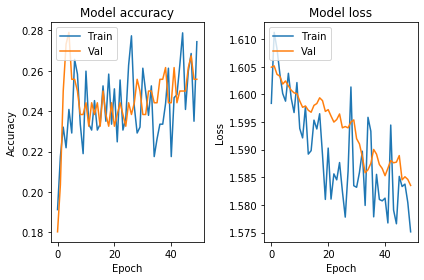

In [48]:
print('optimizer: Adam, epochs: 50, layer sizes: 8')

#getting metrics on test data
score = model.evaluate(test_img, test_lbl, verbose=0)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation acc values
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
fig = plt.show()


In [49]:

optimizer = tf.keras.optimizers.Adam()

model = tf.keras.Sequential()
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.2))
    
    #adding 1st layer, w 10 nodes
model.add(tf.keras.layers.Dense(8, input_shape = (19,), activation="relu", kernel_initializer = 'random_uniform'))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))

#adding 2nd layer, w 10 nodes
model.add(tf.keras.layers.Dense(8, activation="relu"))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))
    
    #adding last layer, w/5nodes, softmax
model.add(tf.keras.layers.Dense(5, activation="softmax"))
    
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'])


history = model.fit(train_img, train_lbl,validation_split=0.2, epochs=100, verbose=1)




Train on 685 samples, validate on 172 samples
Epoch 1/100
685/685 [==============================] - 1s 864us/sample - loss: 1.6152 - acc: 0.2117 - val_loss: 1.6083 - val_acc: 0.2267
Epoch 2/100
685/685 [==============================] - 0s 128us/sample - loss: 1.6111 - acc: 0.2131 - val_loss: 1.6088 - val_acc: 0.1860
Epoch 3/100
685/685 [==============================] - 0s 128us/sample - loss: 1.6057 - acc: 0.2146 - val_loss: 1.6069 - val_acc: 0.2035
Epoch 4/100
685/685 [==============================] - 0s 122us/sample - loss: 1.6051 - acc: 0.2175 - val_loss: 1.6100 - val_acc: 0.1977
Epoch 5/100
685/685 [==============================] - 0s 126us/sample - loss: 1.6093 - acc: 0.2409 - val_loss: 1.6102 - val_acc: 0.1802
Epoch 6/100
685/685 [==============================] - 0s 119us/sample - loss: 1.6033 - acc: 0.2350 - val_loss: 1.6098 - val_acc: 0.1860
Epoch 7/100
685/685 [==============================] - 0s 112us/sample - loss: 1.6041 - acc: 0.2307 - val_loss: 1.6092 - val_acc: 0.

optimizer: Adam, epochs: 100, layer sizes: 8
Test loss score: 1.580509079086197
Test accuracy: 0.28671327


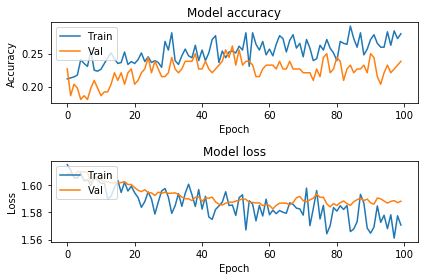

In [50]:
print('optimizer: Adam, epochs: 100, layer sizes: 8')

#getting metrics on test data
score = model.evaluate(test_img, test_lbl, verbose=0)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation acc values
plt.subplot(2, 1, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
fig = plt.show()


In [51]:

optimizer = tf.keras.optimizers.Adam()

model = tf.keras.Sequential()
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.2))
    
    #adding 1st layer, w 10 nodes
model.add(tf.keras.layers.Dense(8, input_shape = (19,), activation="relu", kernel_initializer = 'random_uniform'))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))

#adding 2nd layer, w 10 nodes
model.add(tf.keras.layers.Dense(8, activation="relu"))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))
    
    #adding last layer, w/5nodes, softmax
model.add(tf.keras.layers.Dense(5, activation="softmax"))
    
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'])


history = model.fit(train_img, train_lbl,validation_split=0.2, epochs=500, verbose=1)




Train on 685 samples, validate on 172 samples
Epoch 1/500
685/685 [==============================] - 0s 680us/sample - loss: 1.6187 - acc: 0.1985 - val_loss: 1.6008 - val_acc: 0.2093
Epoch 2/500
685/685 [==============================] - 0s 111us/sample - loss: 1.6142 - acc: 0.1912 - val_loss: 1.5994 - val_acc: 0.2209
Epoch 3/500
685/685 [==============================] - 0s 95us/sample - loss: 1.6166 - acc: 0.2204 - val_loss: 1.6086 - val_acc: 0.1977
Epoch 4/500
685/685 [==============================] - 0s 95us/sample - loss: 1.6065 - acc: 0.2000 - val_loss: 1.6081 - val_acc: 0.1802
Epoch 5/500
685/685 [==============================] - 0s 94us/sample - loss: 1.6064 - acc: 0.2277 - val_loss: 1.6065 - val_acc: 0.1686
Epoch 6/500
685/685 [==============================] - 0s 105us/sample - loss: 1.6049 - acc: 0.2219 - val_loss: 1.6036 - val_acc: 0.2035
Epoch 7/500
685/685 [==============================] - 0s 94us/sample - loss: 1.6063 - acc: 0.2102 - val_loss: 1.6009 - val_acc: 0.2326

optimizer: Adam, epochs: 500, layer sizes: 8
Test loss score: 1.5552121267452106
Test accuracy: 0.30769232


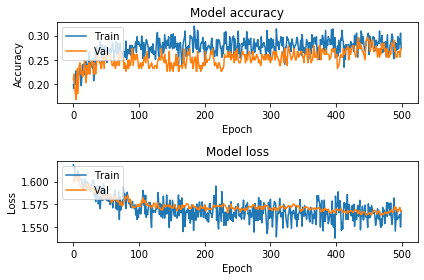

In [52]:
print('optimizer: Adam, epochs: 500, layer sizes: 8')

#getting metrics on test data
score = model.evaluate(test_img, test_lbl, verbose=0)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation acc values
plt.subplot(2, 1, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 1, 2) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.tight_layout()
fig = plt.show()


#### 2)

In [53]:

optimizer = tf.keras.optimizers.Adam()

model = tf.keras.Sequential()
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.2))
    
    #adding 1st layer, w 10 nodes
model.add(tf.keras.layers.Dense(64, input_shape = (19,), activation="relu", kernel_initializer = 'random_uniform'))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))

#adding 2nd layer, w 10 nodes
model.add(tf.keras.layers.Dense(64, activation="relu"))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))
    
    #adding last layer, w/5nodes, softmax
model.add(tf.keras.layers.Dense(5, activation="softmax"))
    
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'])


history = model.fit(train_img, train_lbl,validation_split=0.2, epochs=50, verbose=1)




Train on 685 samples, validate on 172 samples
Epoch 1/50
685/685 [==============================] - 1s 817us/sample - loss: 1.6109 - acc: 0.2146 - val_loss: 1.5935 - val_acc: 0.1628
Epoch 2/50
685/685 [==============================] - 0s 117us/sample - loss: 1.5980 - acc: 0.2248 - val_loss: 1.5956 - val_acc: 0.2151
Epoch 3/50
685/685 [==============================] - 0s 102us/sample - loss: 1.5963 - acc: 0.2350 - val_loss: 1.5953 - val_acc: 0.2151
Epoch 4/50
685/685 [==============================] - 0s 91us/sample - loss: 1.5947 - acc: 0.2248 - val_loss: 1.5952 - val_acc: 0.2267
Epoch 5/50
685/685 [==============================] - 0s 91us/sample - loss: 1.5908 - acc: 0.2482 - val_loss: 1.5892 - val_acc: 0.2558
Epoch 6/50
685/685 [==============================] - 0s 111us/sample - loss: 1.5826 - acc: 0.2730 - val_loss: 1.5846 - val_acc: 0.2558
Epoch 7/50
685/685 [==============================] - 0s 111us/sample - loss: 1.5724 - acc: 0.2891 - val_loss: 1.5794 - val_acc: 0.2616
Epoc

optimizer: Adam, epochs: 50, layer sizes: 64
Test loss score: 1.5268960215828635
Test accuracy: 0.37062937


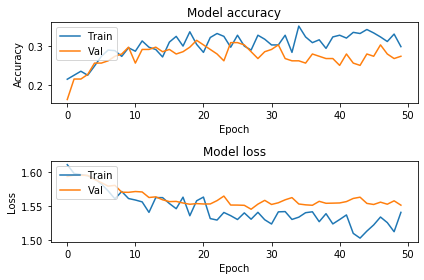

In [54]:
print('optimizer: Adam, epochs: 50, layer sizes: 64')

#getting metrics on test data
score = model.evaluate(test_img, test_lbl, verbose=0)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation acc values
plt.subplot(2, 1, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
fig = plt.show()


In [55]:

optimizer = tf.keras.optimizers.Adam()

model = tf.keras.Sequential()
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.2))
    
    #adding 1st layer, w 64 nodes
model.add(tf.keras.layers.Dense(64, input_shape = (19,), activation="relu", kernel_initializer = 'random_uniform'))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))

#adding 2nd layer, w 64 nodes
model.add(tf.keras.layers.Dense(64, activation="relu"))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))
    
    #adding last layer, w/5nodes, softmax
model.add(tf.keras.layers.Dense(5, activation="softmax"))
    
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'])


history = model.fit(train_img, train_lbl,validation_split=0.2, epochs=100, verbose=1)




Train on 685 samples, validate on 172 samples
Epoch 1/100
685/685 [==============================] - 1s 833us/sample - loss: 1.6156 - acc: 0.2015 - val_loss: 1.6020 - val_acc: 0.2151
Epoch 2/100
685/685 [==============================] - 0s 111us/sample - loss: 1.6118 - acc: 0.1927 - val_loss: 1.5945 - val_acc: 0.2326
Epoch 3/100
685/685 [==============================] - 0s 117us/sample - loss: 1.6053 - acc: 0.2496 - val_loss: 1.5915 - val_acc: 0.2326
Epoch 4/100
685/685 [==============================] - 0s 126us/sample - loss: 1.5932 - acc: 0.2569 - val_loss: 1.5888 - val_acc: 0.2326
Epoch 5/100
685/685 [==============================] - 0s 120us/sample - loss: 1.5698 - acc: 0.2745 - val_loss: 1.5858 - val_acc: 0.2384
Epoch 6/100
685/685 [==============================] - 0s 125us/sample - loss: 1.5840 - acc: 0.2599 - val_loss: 1.5814 - val_acc: 0.2384
Epoch 7/100
685/685 [==============================] - 0s 123us/sample - loss: 1.5643 - acc: 0.2920 - val_loss: 1.5790 - val_acc: 0.

optimizer: Adam, epochs: 100, layer sizes: 64
Test loss score: 1.5165602635670374
Test accuracy: 0.34265736


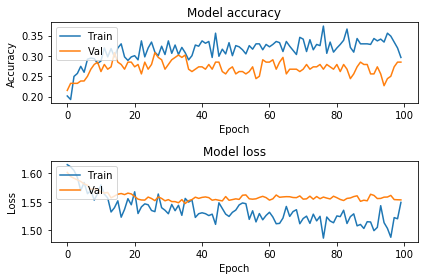

In [56]:
print('optimizer: Adam, epochs: 100, layer sizes: 64')

#getting metrics on test data
score = model.evaluate(test_img, test_lbl, verbose=0)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation acc values
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
fig = plt.show()


In [57]:

optimizer = tf.keras.optimizers.Adam()

model = tf.keras.Sequential()
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.2))
    
    #adding 1st layer, w 64 nodes
model.add(tf.keras.layers.Dense(64, input_shape = (19,), activation="relu", kernel_initializer = 'random_uniform'))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))

#adding 2nd layer, w 64 nodes
model.add(tf.keras.layers.Dense(64, activation="relu"))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))
    
    #adding last layer, w/5nodes, softmax
model.add(tf.keras.layers.Dense(5, activation="softmax"))
    
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'])


history = model.fit(train_img, train_lbl,validation_split=0.2, epochs=500, verbose=1)




Train on 685 samples, validate on 172 samples
Epoch 1/500
685/685 [==============================] - 1s 951us/sample - loss: 1.6084 - acc: 0.2248 - val_loss: 1.6036 - val_acc: 0.2209
Epoch 2/500
685/685 [==============================] - 0s 124us/sample - loss: 1.5980 - acc: 0.2307 - val_loss: 1.5978 - val_acc: 0.2151
Epoch 3/500
685/685 [==============================] - 0s 116us/sample - loss: 1.5912 - acc: 0.2599 - val_loss: 1.5933 - val_acc: 0.2326
Epoch 4/500
685/685 [==============================] - 0s 109us/sample - loss: 1.5710 - acc: 0.2920 - val_loss: 1.5857 - val_acc: 0.2733
Epoch 5/500
685/685 [==============================] - 0s 114us/sample - loss: 1.5792 - acc: 0.2774 - val_loss: 1.5844 - val_acc: 0.2616
Epoch 6/500
685/685 [==============================] - 0s 114us/sample - loss: 1.5859 - acc: 0.2482 - val_loss: 1.5832 - val_acc: 0.2674
Epoch 7/500
685/685 [==============================] - 0s 121us/sample - loss: 1.5662 - acc: 0.2832 - val_loss: 1.5793 - val_acc: 0.

optimizer: Adam, epochs: 500, layer sizes: 64
Test loss score: 1.5321731442338102
Test accuracy: 0.37062937


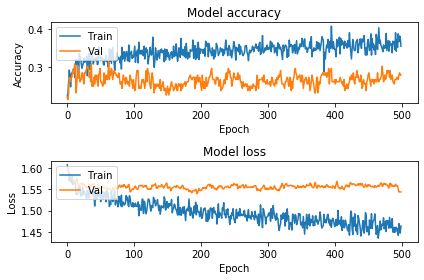

In [58]:
print('optimizer: Adam, epochs: 500, layer sizes: 64')

#getting metrics on test data
score = model.evaluate(test_img, test_lbl, verbose=0)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation acc values
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
fig = plt.show()


In [59]:

optimizer = tf.keras.optimizers.Adam()

model = tf.keras.Sequential()
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.2))
    
    #adding 1st layer, w 64 nodes
model.add(tf.keras.layers.Dense(128, input_shape = (19,), activation="relu", kernel_initializer = 'random_uniform'))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))

#adding 2nd layer, w 64 nodes
model.add(tf.keras.layers.Dense(128, activation="relu"))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))
    
    #adding last layer, w/5nodes, softmax
model.add(tf.keras.layers.Dense(5, activation="softmax"))
    
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'])


history = model.fit(train_img, train_lbl,validation_split=0.2, epochs=50, verbose=1)




Train on 685 samples, validate on 172 samples
Epoch 1/50
685/685 [==============================] - 1s 1ms/sample - loss: 1.6202 - acc: 0.1985 - val_loss: 1.6017 - val_acc: 0.2035
Epoch 2/50
685/685 [==============================] - 0s 113us/sample - loss: 1.5891 - acc: 0.2540 - val_loss: 1.5982 - val_acc: 0.1860
Epoch 3/50
685/685 [==============================] - 0s 106us/sample - loss: 1.6003 - acc: 0.2613 - val_loss: 1.5951 - val_acc: 0.2326
Epoch 4/50
685/685 [==============================] - 0s 105us/sample - loss: 1.5708 - acc: 0.2832 - val_loss: 1.5869 - val_acc: 0.2384
Epoch 5/50
685/685 [==============================] - 0s 111us/sample - loss: 1.5744 - acc: 0.2905 - val_loss: 1.5882 - val_acc: 0.2500
Epoch 6/50
685/685 [==============================] - 0s 110us/sample - loss: 1.5531 - acc: 0.3051 - val_loss: 1.5774 - val_acc: 0.2500
Epoch 7/50
685/685 [==============================] - 0s 102us/sample - loss: 1.5670 - acc: 0.2993 - val_loss: 1.5748 - val_acc: 0.2558
Epoc

optimizer: Adam, epochs: 50, layer sizes: 128
Test loss score: 1.5205936790346266
Test accuracy: 0.35664335


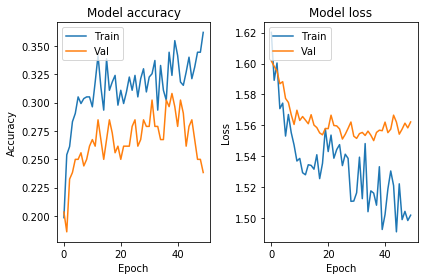

In [60]:
print('optimizer: Adam, epochs: 50, layer sizes: 128')

#getting metrics on test data
score = model.evaluate(test_img, test_lbl, verbose=0)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation acc values
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
fig = plt.show()


In [61]:

optimizer = tf.keras.optimizers.Adam()

model = tf.keras.Sequential()
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.2))
    
    #adding 1st layer, w 64 nodes
model.add(tf.keras.layers.Dense(128, input_shape = (19,), activation="relu", kernel_initializer = 'random_uniform'))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))

#adding 2nd layer, w 64 nodes
model.add(tf.keras.layers.Dense(128, activation="relu"))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))
    
    #adding last layer, w/5nodes, softmax
model.add(tf.keras.layers.Dense(5, activation="softmax"))
    
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'])


history = model.fit(train_img, train_lbl,validation_split=0.2, epochs=100, verbose=1)




Train on 685 samples, validate on 172 samples
Epoch 1/100
685/685 [==============================] - 1s 1ms/sample - loss: 1.6152 - acc: 0.1985 - val_loss: 1.6080 - val_acc: 0.2500
Epoch 2/100
685/685 [==============================] - 0s 128us/sample - loss: 1.5895 - acc: 0.2628 - val_loss: 1.6004 - val_acc: 0.2500
Epoch 3/100
685/685 [==============================] - 0s 140us/sample - loss: 1.5911 - acc: 0.2642 - val_loss: 1.5899 - val_acc: 0.2500
Epoch 4/100
685/685 [==============================] - 0s 134us/sample - loss: 1.5829 - acc: 0.2701 - val_loss: 1.5838 - val_acc: 0.2849
Epoch 5/100
685/685 [==============================] - 0s 128us/sample - loss: 1.5689 - acc: 0.2847 - val_loss: 1.5743 - val_acc: 0.2791
Epoch 6/100
685/685 [==============================] - 0s 127us/sample - loss: 1.5529 - acc: 0.2905 - val_loss: 1.5711 - val_acc: 0.2791
Epoch 7/100
685/685 [==============================] - 0s 132us/sample - loss: 1.5766 - acc: 0.2993 - val_loss: 1.5689 - val_acc: 0.29

optimizer: Adam, epochs: 100, layer sizes: 128
Test loss score: 1.5277309826203993
Test accuracy: 0.36363637


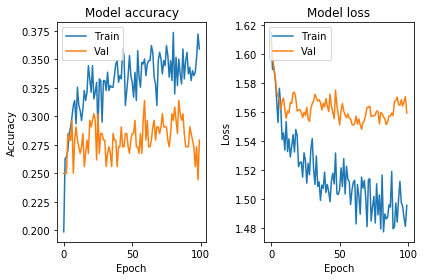

In [62]:
print('optimizer: Adam, epochs: 100, layer sizes: 128')

#getting metrics on test data
score = model.evaluate(test_img, test_lbl, verbose=0)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation acc values
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
fig = plt.show()


In [63]:

optimizer = tf.keras.optimizers.Adam()

model = tf.keras.Sequential()
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.2))
    
    #adding 1st layer, w 64 nodes
model.add(tf.keras.layers.Dense(128, input_shape = (19,), activation="relu", kernel_initializer = 'random_uniform'))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))

#adding 2nd layer, w 64 nodes
model.add(tf.keras.layers.Dense(128, activation="relu"))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))
    
    #adding last layer, w/5nodes, softmax
model.add(tf.keras.layers.Dense(5, activation="softmax"))
    
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'])


history = model.fit(train_img, train_lbl,validation_split=0.2, epochs=500, verbose=1)




Train on 685 samples, validate on 172 samples
Epoch 1/500
685/685 [==============================] - 1s 1ms/sample - loss: 1.6044 - acc: 0.2453 - val_loss: 1.5961 - val_acc: 0.2326
Epoch 2/500
685/685 [==============================] - 0s 146us/sample - loss: 1.5937 - acc: 0.2467 - val_loss: 1.5894 - val_acc: 0.2326
Epoch 3/500
685/685 [==============================] - 0s 139us/sample - loss: 1.5945 - acc: 0.2715 - val_loss: 1.5843 - val_acc: 0.2442
Epoch 4/500
685/685 [==============================] - 0s 153us/sample - loss: 1.5812 - acc: 0.2511 - val_loss: 1.5826 - val_acc: 0.2791
Epoch 5/500
685/685 [==============================] - 0s 148us/sample - loss: 1.5638 - acc: 0.2861 - val_loss: 1.5764 - val_acc: 0.2733
Epoch 6/500
685/685 [==============================] - 0s 145us/sample - loss: 1.5563 - acc: 0.2774 - val_loss: 1.5791 - val_acc: 0.2733
Epoch 7/500
685/685 [==============================] - 0s 159us/sample - loss: 1.5553 - acc: 0.3095 - val_loss: 1.5741 - val_acc: 0.26

optimizer: Adam, epochs: 500, layer sizes: 128
Test loss score: 1.5920372259366762
Test accuracy: 0.37762237


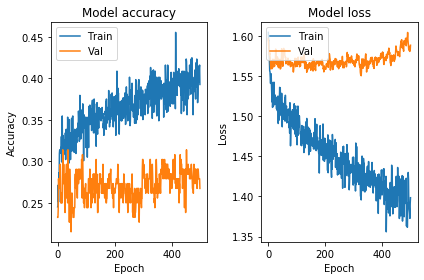

In [64]:
print('optimizer: Adam, epochs: 500, layer sizes: 128')

#getting metrics on test data
score = model.evaluate(test_img, test_lbl, verbose=0)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation acc values
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
fig = plt.show()


In [80]:

optimizer = tf.keras.optimizers.Adam()

model = tf.keras.Sequential()
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.2))
    
    #adding 1st layer, w 64 nodes
model.add(tf.keras.layers.Dense(128, input_shape = (19,), activation="relu", kernel_initializer = 'random_uniform'))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))

#adding 2nd layer, w 64 nodes
model.add(tf.keras.layers.Dense(128, activation="relu"))
    
    #dropout layer
model.add(tf.keras.layers.Dropout(rate = 0.5))
    
    #adding last layer, w/5nodes, softmax
model.add(tf.keras.layers.Dense(5, activation="softmax"))
    
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                metrics=['accuracy'])


history = model.fit(train_img, train_lbl,validation_split=0.2, epochs=600, verbose=1)




Train on 685 samples, validate on 172 samples
Epoch 1/600
685/685 [==============================] - 1s 1ms/sample - loss: 1.6174 - acc: 0.2088 - val_loss: 1.6067 - val_acc: 0.1686
Epoch 2/600
685/685 [==============================] - 0s 115us/sample - loss: 1.5814 - acc: 0.2555 - val_loss: 1.6002 - val_acc: 0.2151
Epoch 3/600
685/685 [==============================] - 0s 102us/sample - loss: 1.5816 - acc: 0.2803 - val_loss: 1.5949 - val_acc: 0.2326
Epoch 4/600
685/685 [==============================] - 0s 114us/sample - loss: 1.5673 - acc: 0.2672 - val_loss: 1.5901 - val_acc: 0.2442
Epoch 5/600
685/685 [==============================] - 0s 116us/sample - loss: 1.5565 - acc: 0.2964 - val_loss: 1.5843 - val_acc: 0.2442
Epoch 6/600
685/685 [==============================] - 0s 105us/sample - loss: 1.5565 - acc: 0.2978 - val_loss: 1.5674 - val_acc: 0.2907
Epoch 7/600
685/685 [==============================] - 0s 102us/sample - loss: 1.5580 - acc: 0.2891 - val_loss: 1.5668 - val_acc: 0.26

optimizer: Adam, epochs: 600, layer sizes: 128
Test loss score: 1.633004269399843
Test accuracy: 0.30769232


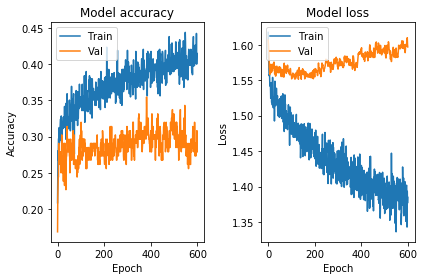

In [81]:
print('optimizer: Adam, epochs: 600, layer sizes: 128')

#getting metrics on test data
score = model.evaluate(test_img, test_lbl, verbose=0)
print('Test loss score:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation acc values
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
fig = plt.show()

##  Trying Neural Net w/ Scikit MLP Classifier


In [67]:
mlp = MLPClassifier(solver='lbfgs')
mlp.hidden_layer_sizes = (8, 8)

In [68]:
mlp.fit(train_img, train_lbl)
print("Training set score: %f" % mlp.score(train_img, train_lbl))
print("Test set score: %f" % mlp.score(test_img, test_lbl))

Training set score: 0.199533
Test set score: 0.195804


In [69]:
mlp = MLPClassifier(solver='lbfgs')
mlp.hidden_layer_sizes = (64, 64)

In [70]:
mlp.fit(train_img, train_lbl)
print("Training set score: %f" % mlp.score(train_img, train_lbl))
print("Test set score: %f" % mlp.score(test_img, test_lbl))

Training set score: 0.739790
Test set score: 0.216783


In [71]:
mlp = MLPClassifier(solver='lbfgs')
mlp.hidden_layer_sizes = (128, 128)

In [72]:
mlp.fit(train_img, train_lbl)
print("Training set score: %f" % mlp.score(train_img, train_lbl))
print("Test set score: %f" % mlp.score(test_img, test_lbl))

Training set score: 0.882147
Test set score: 0.174825
